## Dependencies

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
plt.rcParams.update({'font.size': 10, 'figure.dpi': 300})

## Dataset

In [3]:
# reading in the heart disease dataset
df = pd.read_csv('../data/heart_disease_dataset.csv')

display(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,location
0,63.0,Male,Typical Angina,145.0,233.0,Above 120,LV Hypertrophy,150.0,Exercise Angina Absent,2.3,Down,0 Vessel(s),Fixed Defect,0,Cleveland
1,67.0,Male,Asymptomatic,160.0,286.0,Below 120,LV Hypertrophy,108.0,Exercise Angina Present,1.5,Flat,3 Vessel(s),Normal,1,Cleveland
2,67.0,Male,Asymptomatic,120.0,229.0,Below 120,LV Hypertrophy,129.0,Exercise Angina Present,2.6,Flat,2 Vessel(s),Reversable Defect,1,Cleveland
3,37.0,Male,Nonanginal Pain,130.0,250.0,Below 120,Normal,187.0,Exercise Angina Absent,3.5,Down,0 Vessel(s),Normal,0,Cleveland
4,41.0,Female,Atypical Angina,130.0,204.0,Below 120,LV Hypertrophy,172.0,Exercise Angina Absent,1.4,Up,0 Vessel(s),Normal,0,Cleveland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,54.0,Female,Asymptomatic,127.0,333.0,Above 120,ST-T Abnormality,154.0,Exercise Angina Absent,0.0,NaN,NaN,NaN,1,Long Beach
793,62.0,Male,Typical Angina,NaN,139.0,Below 120,ST-T Abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0,Long Beach
794,55.0,Male,Asymptomatic,122.0,223.0,Above 120,ST-T Abnormality,100.0,Exercise Angina Absent,0.0,NaN,NaN,Fixed Defect,1,Long Beach
795,58.0,Male,Asymptomatic,NaN,385.0,Above 120,LV Hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0,Long Beach


## Statistics

In [4]:
# initializing the feature matrix and target vector
X = df.drop(['num'], axis=1)
y = df['num']

# initializing the class ratios of the target variable
target_ratios = y.value_counts(normalize=True)

# printing the baseline accuracy of the dataset
baseline_accuracy = target_ratios.max()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 50.56%


## Functions

In [5]:
# defining the MLpipe_GroupKFold_accuracy function
def MLpipe_GroupKFold_AS(X, y, groups, preprocessor, ML_algo, param_grid, trials):
    # initializing the results dictionary
    results = collections.defaultdict(list)

    # iterating through the trials
    for i in range(trials):
        # splitting the dataset into a test set and other set
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=(42 * i))
        other_index, test_index = next(gss.split(X, y, groups=groups))

        X_other, y_other, groups_other = X.iloc[other_index], y.iloc[other_index], groups.iloc[other_index]
        X_test, y_test, groups_test = X.iloc[test_index], y.iloc[test_index], groups.iloc[test_index]

        # initializing GroupKFold as the splitting method
        gkf = GroupKFold(n_splits=2)

        # initializing the pipeline with the preprocessor and machine learning algorithm
        pipe = make_pipeline(preprocessor, ML_algo)
        
        # initializing and fitting GridSearchCV
        grid = GridSearchCV(pipe, param_grid=param_grid, cv=gkf, scoring='accuracy')
        grid.fit(X_other, y_other, groups=groups_other)

        # calculating the test accuracy score
        y_pred = grid.predict(X_test)
        
        test_score = accuracy_score(y_test, y_pred)
        
        # saving the output in the results dictionary
        results['val scores'].append(grid.best_score_)
        results['test scores'].append(test_score)
        results['best models'].append(grid.best_estimator_)
        results['test sets'].append([X_test, y_test])

    # returning the results
    return results

In [6]:
# defining the MLpipe_GroupKFold_F1 function
def MLpipe_GroupKFold_F1(X, y, groups, preprocessor, ML_algo, param_grid, trials):
    # initializing the results dictionary
    results = collections.defaultdict(list)

    # iterating through the trials
    for i in range(trials):
        # splitting the dataset into a test set and other set
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=(42 * i))
        other_index, test_index = next(gss.split(X, y, groups=groups))

        X_other, y_other, groups_other = X.iloc[other_index], y.iloc[other_index], groups.iloc[other_index]
        X_test, y_test, groups_test = X.iloc[test_index], y.iloc[test_index], groups.iloc[test_index]

        # initializing GroupKFold as the splitting method
        gkf = GroupKFold(n_splits=2)

        # initializing the pipeline with the preprocessor and machine learning algorithm
        pipe = make_pipeline(preprocessor, ML_algo)

        # initializing and fitting GridSearchCV
        grid = GridSearchCV(pipe, param_grid=param_grid, cv=gkf, scoring=make_scorer(f1_score))
        grid.fit(X_other, y_other, groups=groups_other)

        # calculating the test f1 score
        y_pred = grid.predict(X_test)
        
        test_score = f1_score(y_test, y_pred)
        
        # saving the output in the results dictionary
        results['val scores'].append(grid.best_score_)
        results['test scores'].append(test_score)
        results['best models'].append(grid.best_estimator_)
        results['test sets'].append([X_test, y_test])

    # returning the results
    return results

In [7]:
# defining the plot_performance function
def plot_performance(model_means, model_stds, baseline_score, scorer):
    # initializing the scorer names
    scorer_names = {'a': 'Accuracy', 'f': 'F1'}

    # plotting the mean and standard deviation of all models
    plt.errorbar(['LR','RF','KNN','SVM','XGB'], model_means, model_stds, linestyle='None', marker='o')
    plt.axhline(y=baseline_score, label='Baseline Accuracy', color='r', linestyle='-')

    plt.title('ML Model Performance & Uncertainty', pad=15)

    plt.xlabel('Machine Learning Model', labelpad=10)
    plt.ylabel(f'{scorer_names[scorer]} Score', labelpad=10)

    ax = plt.gca()
    ax.set_ylim([0.4, 1])

    plt.savefig(f'../figures/mod_figures/performance_{scorer}.png', bbox_inches='tight')

    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    plt.show()

## ML Models

In [8]:
# initializing the random state
random_state = 0

# initializing the number of trials
trials = 20

# initializing the groups
groups = df['location']

In [9]:
# initializing the categorical features and numerical features
cat_ftrs = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'location']
num_ftrs = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

### Logistic Regression

In [10]:
# initializing categorical feature transformer
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ('scaler1', StandardScaler())
])

# initializing numeric feature transformer
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=LinearRegression(), random_state=0)),
    ('scaler2', StandardScaler())
])

# initializing the heart disease dataset preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_ftrs),
    ('num', num_transformer, num_ftrs)
])

In [11]:
# initializing the machine learning algorithm
ML_algo = LogisticRegression(random_state=random_state)

# initializing the parameter grid for the algorithm
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': 1 / np.logspace(-2, 2, 21),
    'logisticregression__max_iter': [10000],
    'logisticregression__multi_class': ['auto'],
    'logisticregression__solver': ['saga']
}

# calling the machine learning pipeline functions
lr_results_a = MLpipe_GroupKFold_AS(X, y, groups, preprocessor, ML_algo, param_grid, trials)
lr_results_f = MLpipe_GroupKFold_F1(X, y, groups, preprocessor, ML_algo, param_grid, trials)

# saving the logistic regression results
with open('../results/LR/logistic_regression_a.pkl', 'wb') as f:
    pickle.dump(lr_results_a, f)

with open('../results/LR/logistic_regression_f.pkl', 'wb') as f:
    pickle.dump(lr_results_f, f)

#### Accuracy Score

In [12]:
# initializing the mean and standard deviation of the val scores
lr_vmean_a = np.mean(lr_results_a['val scores'])
lr_vstd_a = np.std(lr_results_a['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {lr_vmean_a:.2}')
print(f'Validation Scores Standard Deviation: {lr_vstd_a:.2}')

Validation Scores Mean: 0.79
Validation Scores Standard Deviation: 0.025


In [13]:
# initializing the mean and standard deviation of the test scores
lr_tmean_a = np.mean(lr_results_a['test scores'])
lr_tstd_a = np.std(lr_results_a['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {lr_tmean_a:.2}')
print(f'Test Scores Standard Deviation: {lr_tstd_a:.2}')

Test Scores Mean: 0.72
Test Scores Standard Deviation: 0.097


In [14]:
# printing the standard deviations above the baseline
std_above_base = (lr_tmean_a - baseline_accuracy) / lr_tstd_a

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 2.2


#### F1 Score

In [15]:
# initializing the mean and standard deviation of the val scores
lr_vmean_f = np.mean(lr_results_f['val scores'])
lr_vstd_f = np.std(lr_results_f['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {lr_vmean_f:.2}')
print(f'Validation Scores Standard Deviation: {lr_vstd_f:.2}')

Validation Scores Mean: 0.79
Validation Scores Standard Deviation: 0.021


In [16]:
# initializing the mean and standard deviation of the test scores
lr_tmean_f = np.mean(lr_results_f['test scores'])
lr_tstd_f = np.std(lr_results_f['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {lr_tmean_f:.2}')
print(f'Test Scores Standard Deviation: {lr_tstd_f:.2}')

Test Scores Mean: 0.72
Test Scores Standard Deviation: 0.051


In [17]:
# printing the standard deviations above the baseline
std_above_base = (lr_tmean_f - baseline_accuracy) / lr_tstd_f

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 4.2


### Random Forest

In [18]:
# initializing categorical feature transformer
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# initializing numeric feature transformer
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=LinearRegression(), random_state=0)),
    ('scaler', StandardScaler())
])

# initializing the heart disease dataset preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_ftrs),
    ('num', num_transformer, num_ftrs)
])

In [19]:
# initializing the machine learning algorithm
ML_algo = RandomForestClassifier(random_state=random_state)

# initializing the parameter grid for the algorithm
param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],
    'randomforestclassifier__max_features': [0.25, 0.5, 0.75, 1.0]
}

# calling the machine learning pipeline functions
rf_results_a = MLpipe_GroupKFold_AS(X, y, groups, preprocessor, ML_algo, param_grid, trials)
rf_results_f = MLpipe_GroupKFold_F1(X, y, groups, preprocessor, ML_algo, param_grid, trials)

# saving the random forest results
with open('../results/RF/random_forest_a.pkl', 'wb') as f:
    pickle.dump(rf_results_a, f)

with open('../results/RF/random_forest_f.pkl', 'wb') as f:
    pickle.dump(rf_results_f, f)

#### Accuracy Score

In [20]:
# initializing the mean and standard deviation of the test scores
rf_vmean_a = np.mean(rf_results_a['val scores'])
rf_vstd_a = np.std(rf_results_a['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {rf_vmean_a:.2}')
print(f'Validation Scores Standard Deviation: {rf_vstd_a:.2}')

Validation Scores Mean: 0.76
Validation Scores Standard Deviation: 0.053


In [21]:
# initializing the mean and standard deviation of the test scores
rf_tmean_a = np.mean(rf_results_a['test scores'])
rf_tstd_a = np.std(rf_results_a['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {rf_tmean_a:.2}')
print(f'Test Scores Standard Deviation: {rf_tstd_a:.2}')

Test Scores Mean: 0.75
Test Scores Standard Deviation: 0.07


In [22]:
# printing the standard deviations above the baseline
std_above_base = (rf_tmean_a - baseline_accuracy) / rf_tstd_a

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 3.5


#### F1 Score

In [23]:
# initializing the mean and standard deviation of the test scores
rf_vmean_f = np.mean(rf_results_f['val scores'])
rf_vstd_f = np.std(rf_results_f['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {rf_vmean_f:.2}')
print(f'Validation Scores Standard Deviation: {rf_vstd_f:.2}')

Validation Scores Mean: 0.77
Validation Scores Standard Deviation: 0.014


In [24]:
# initializing the mean and standard deviation of the test scores
rf_tmean_f = np.mean(rf_results_f['test scores'])
rf_tstd_f = np.std(rf_results_f['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {rf_tmean_f:.2}')
print(f'Test Scores Standard Deviation: {rf_tstd_f:.2}')

Test Scores Mean: 0.77
Test Scores Standard Deviation: 0.015


In [25]:
# printing the standard deviations above the baseline
std_above_base = (rf_tmean_f - baseline_accuracy) / rf_tstd_f

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 1.7e+01


### KNN

In [26]:
# initializing categorical feature transformer
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# initializing numeric feature transformer
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=LinearRegression(), random_state=0)),
    ('scaler', StandardScaler())
])

# initializing the heart disease dataset preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_ftrs),
    ('num', num_transformer, num_ftrs)
])

In [27]:
# initializing the machine learning algorithm
ML_algo = KNeighborsClassifier()

# initializing the parameter grid for the algorithm
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 100, 10),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

# calling the machine learning pipeline functions
knc_results_a = MLpipe_GroupKFold_AS(X, y, groups, preprocessor, ML_algo, param_grid, trials)
knc_results_f = MLpipe_GroupKFold_F1(X, y, groups, preprocessor, ML_algo, param_grid, trials)

# saving the n nearest neighbors results
with open('../results/KNN/k_nearest_neighbors_a.pkl', 'wb') as f:
    pickle.dump(knc_results_a, f)

with open('../results/KNN/k_nearest_neighbors_f.pkl', 'wb') as f:
    pickle.dump(knc_results_f, f)

#### Accuracy Score

In [28]:
# initializing the mean and standard deviation of the test scores
knc_vmean_a = np.mean(knc_results_a['val scores'])
knc_vstd_a = np.std(knc_results_a['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {knc_vmean_a:.2}')
print(f'Validation Scores Standard Deviation: {knc_vstd_a:.2}')

Validation Scores Mean: 0.73
Validation Scores Standard Deviation: 0.077


In [29]:
# initializing the mean and standard deviation of the test scores
knc_tmean_a = np.mean(knc_results_a['test scores'])
knc_tstd_a = np.std(knc_results_a['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {knc_tmean_a:.2}')
print(f'Test Scores Standard Deviation: {knc_tstd_a:.2}')

Test Scores Mean: 0.7
Test Scores Standard Deviation: 0.036


In [30]:
# printing the standard deviations above the baseline
std_above_base = (knc_tmean_a - baseline_accuracy) / knc_tstd_a

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 5.3


#### F1 Score

In [31]:
# initializing the mean and standard deviation of the test scores
knc_vmean_f = np.mean(knc_results_f['val scores'])
knc_vstd_f = np.std(knc_results_f['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {knc_vmean_f:.2}')
print(f'Validation Scores Standard Deviation: {knc_vstd_f:.2}')

Validation Scores Mean: 0.75
Validation Scores Standard Deviation: 0.011


In [32]:
# initializing the mean and standard deviation of the test scores
knc_tmean_f = np.mean(knc_results_f['test scores'])
knc_tstd_f = np.std(knc_results_f['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {knc_tmean_f:.2}')
print(f'Test Scores Standard Deviation: {knc_tstd_f:.2}')

Test Scores Mean: 0.74
Test Scores Standard Deviation: 0.039


In [33]:
# printing the standard deviations above the baseline
std_above_base = (knc_tmean_f - baseline_accuracy) / knc_tstd_f

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 6.0


### SVM

In [34]:
# initializing categorical feature transformer
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# initializing numeric feature transformer
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=LinearRegression(), random_state=0)),
    ('scaler', StandardScaler())
])

# initializing the heart disease dataset preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_ftrs),
    ('num', num_transformer, num_ftrs)
])

In [35]:
# initializing the machine learning algorithm
ML_algo = SVC(kernel="rbf", probability=True, random_state=random_state)

# initializing the parameter grid for the algorithm
param_grid = {
    'svc__C': np.logspace(-1, 1, 10),
    'svc__gamma': list(np.logspace(-1, 1, 10)) + ['scale']
}

# calling the machine learning pipeline functions
svc_results_a = MLpipe_GroupKFold_AS(X, y, groups, preprocessor, ML_algo, param_grid, trials)
svc_results_f = MLpipe_GroupKFold_F1(X, y, groups, preprocessor, ML_algo, param_grid, trials)

# saving the support vector machine results
with open('../results/SVM/support_vector_machine_a.pkl', 'wb') as f:
    pickle.dump(svc_results_a, f)

with open('../results/SVM/support_vector_machine_f.pkl', 'wb') as f:
    pickle.dump(svc_results_f, f)

#### Accuracy Score

In [36]:
# initializing the mean and standard deviation of the test scores
svc_vmean_a = np.mean(svc_results_a['val scores'])
svc_vstd_a = np.std(svc_results_a['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {svc_vmean_a:.2}')
print(f'Validation Scores Standard Deviation: {svc_vstd_a:.2}')

Validation Scores Mean: 0.77
Validation Scores Standard Deviation: 0.042


In [37]:
# initializing the mean and standard deviation of the test scores
svc_tmean_a = np.mean(svc_results_a['test scores'])
svc_tstd_a = np.std(svc_results_a['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {svc_tmean_a:.2}')
print(f'Test Scores Standard Deviation: {svc_tstd_a:.2}')

Test Scores Mean: 0.76
Test Scores Standard Deviation: 0.045


In [38]:
# printing the standard deviations above the baseline
std_above_base = (svc_tmean_a - baseline_accuracy) / svc_tstd_a

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 5.6


#### F1 Score

In [39]:
# initializing the mean and standard deviation of the test scores
svc_vmean_f = np.mean(svc_results_f['val scores'])
svc_vstd_f = np.std(svc_results_f['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {svc_vmean_f:.2}')
print(f'Validation Scores Standard Deviation: {svc_vstd_f:.2}')

Validation Scores Mean: 0.78
Validation Scores Standard Deviation: 0.011


In [40]:
# initializing the mean and standard deviation of the test scores
svc_tmean_f = np.mean(svc_results_f['test scores'])
svc_tstd_f = np.std(svc_results_f['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {svc_tmean_f:.2}')
print(f'Test Scores Standard Deviation: {svc_tstd_f:.2}')

Test Scores Mean: 0.79
Test Scores Standard Deviation: 0.032


In [41]:
# printing the standard deviations above the baseline
std_above_base = (svc_tmean_f - baseline_accuracy) / svc_tstd_f

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 8.9


### XGBoost

In [42]:
# initializing categorical feature transformer
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# initializing numeric feature transformer
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# initializing the heart disease dataset preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_ftrs),
    ('num', num_transformer, num_ftrs)
])

In [43]:
# initializing the machine learning algorithm
ML_algo = XGBClassifier(random_state=random_state)

# initializing the parameter grid for the algorithm
param_grid = {
    'xgbclassifier__learning_rate': [0.03],
    'xgbclassifier__n_estimators': [10000],
    'xgbclassifier__seed': [0],
    'xgbclassifier__missing': [np.nan], 
    'xgbclassifier__max_depth': [1,3,10,30,100],
    'xgbclassifier__colsample_bytree': [0.9],    
    'xgbclassifier__subsample': [0.66]
}

# calling the machine learning pipeline functions
xgb_results_a = MLpipe_GroupKFold_AS(X, y, groups, preprocessor, ML_algo, param_grid, trials)
xgb_results_f = MLpipe_GroupKFold_F1(X, y, groups, preprocessor, ML_algo, param_grid, trials)

# saving the extreme gradient boosting results
with open('../results/XGB/extreme_gradient_boosting_a.pkl', 'wb') as f:
    pickle.dump(xgb_results_a, f)

# saving the extreme gradient boosting results
with open('../results/XGB/extreme_gradient_boosting_f.pkl', 'wb') as f:
    pickle.dump(xgb_results_f, f)

#### Accuracy Score

In [44]:
# initializing the mean and standard deviation of the test scores
xgb_vmean_a = np.mean(xgb_results_a['val scores'])
xgb_vstd_a = np.std(xgb_results_a['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {xgb_vmean_a:.2}')
print(f'Validation Scores Standard Deviation: {xgb_vstd_a:.2}')

Validation Scores Mean: 0.69
Validation Scores Standard Deviation: 0.034


In [45]:
# initializing the mean and standard deviation of the test scores
xgb_tmean_a = np.mean(xgb_results_a['test scores'])
xgb_tstd_a = np.std(xgb_results_a['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {xgb_tmean_a:.2}')
print(f'Test Scores Standard Deviation: {xgb_tstd_a:.2}')

Test Scores Mean: 0.7
Test Scores Standard Deviation: 0.065


In [46]:
# printing the standard deviations above the baseline
std_above_base = (xgb_tmean_a - baseline_accuracy) / xgb_tstd_a

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 3.0


#### F1 Score

In [47]:
# initializing the mean and standard deviation of the test scores
xgb_vmean_f = np.mean(xgb_results_f['val scores'])
xgb_vstd_f = np.std(xgb_results_f['val scores'])

# printing the mean and standard deviation of the val scores
print(f'Validation Scores Mean: {xgb_vmean_f:.2}')
print(f'Validation Scores Standard Deviation: {xgb_vstd_f:.2}')

Validation Scores Mean: 0.71
Validation Scores Standard Deviation: 0.05


In [48]:
# initializing the mean and standard deviation of the test scores
xgb_tmean_f = np.mean(xgb_results_f['test scores'])
xgb_tstd_f = np.std(xgb_results_f['test scores'])

# printing the mean and standard deviation of the test scores
print(f'Test Scores Mean: {xgb_tmean_f:.2}')
print(f'Test Scores Standard Deviation: {xgb_tstd_f:.2}')

Test Scores Mean: 0.72
Test Scores Standard Deviation: 0.021


In [49]:
# printing the standard deviations above the baseline
std_above_base = (xgb_tmean_f - baseline_accuracy) / xgb_tstd_f

print(f'Standard Deviations Above Baseline: {std_above_base:.2}')

Standard Deviations Above Baseline: 1e+01


### Measuring Uncertainty

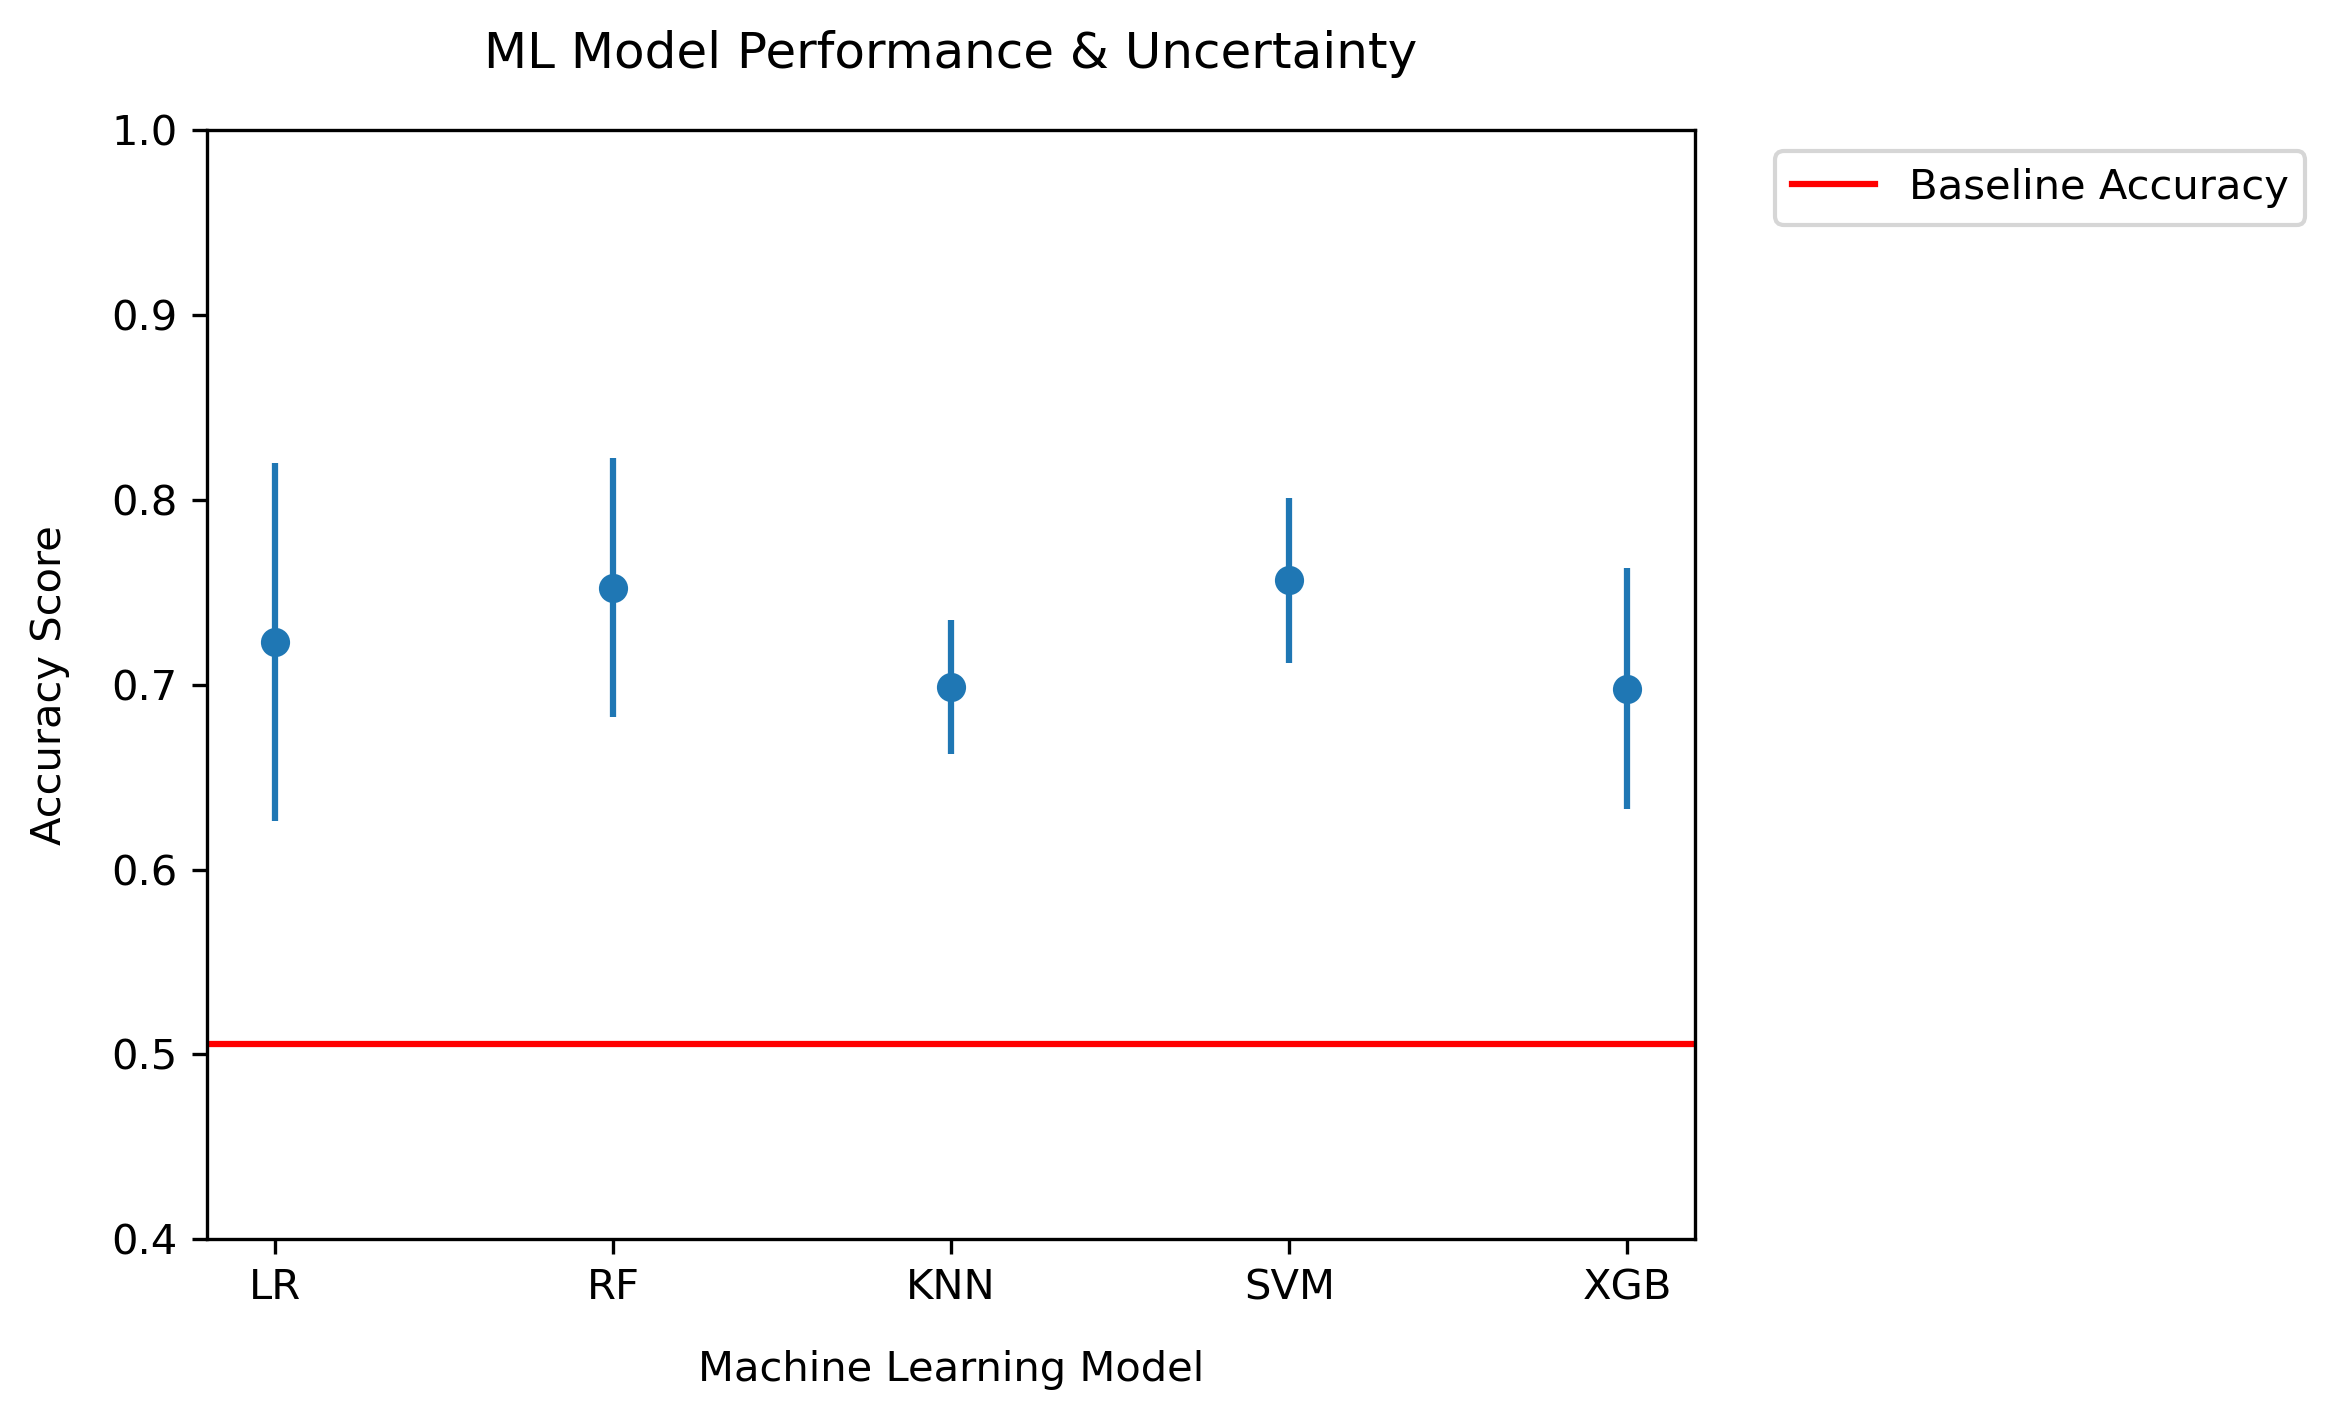

In [50]:
# plotting the performance and uncertainty of the machine learning algorithms
model_means = [lr_tmean_a, rf_tmean_a, knc_tmean_a, svc_tmean_a, xgb_tmean_a]
model_stds = [lr_tstd_a, rf_tstd_a, knc_tstd_a, svc_tstd_a, xgb_tstd_a]

plot_performance(model_means, model_stds, baseline_accuracy, 'a')

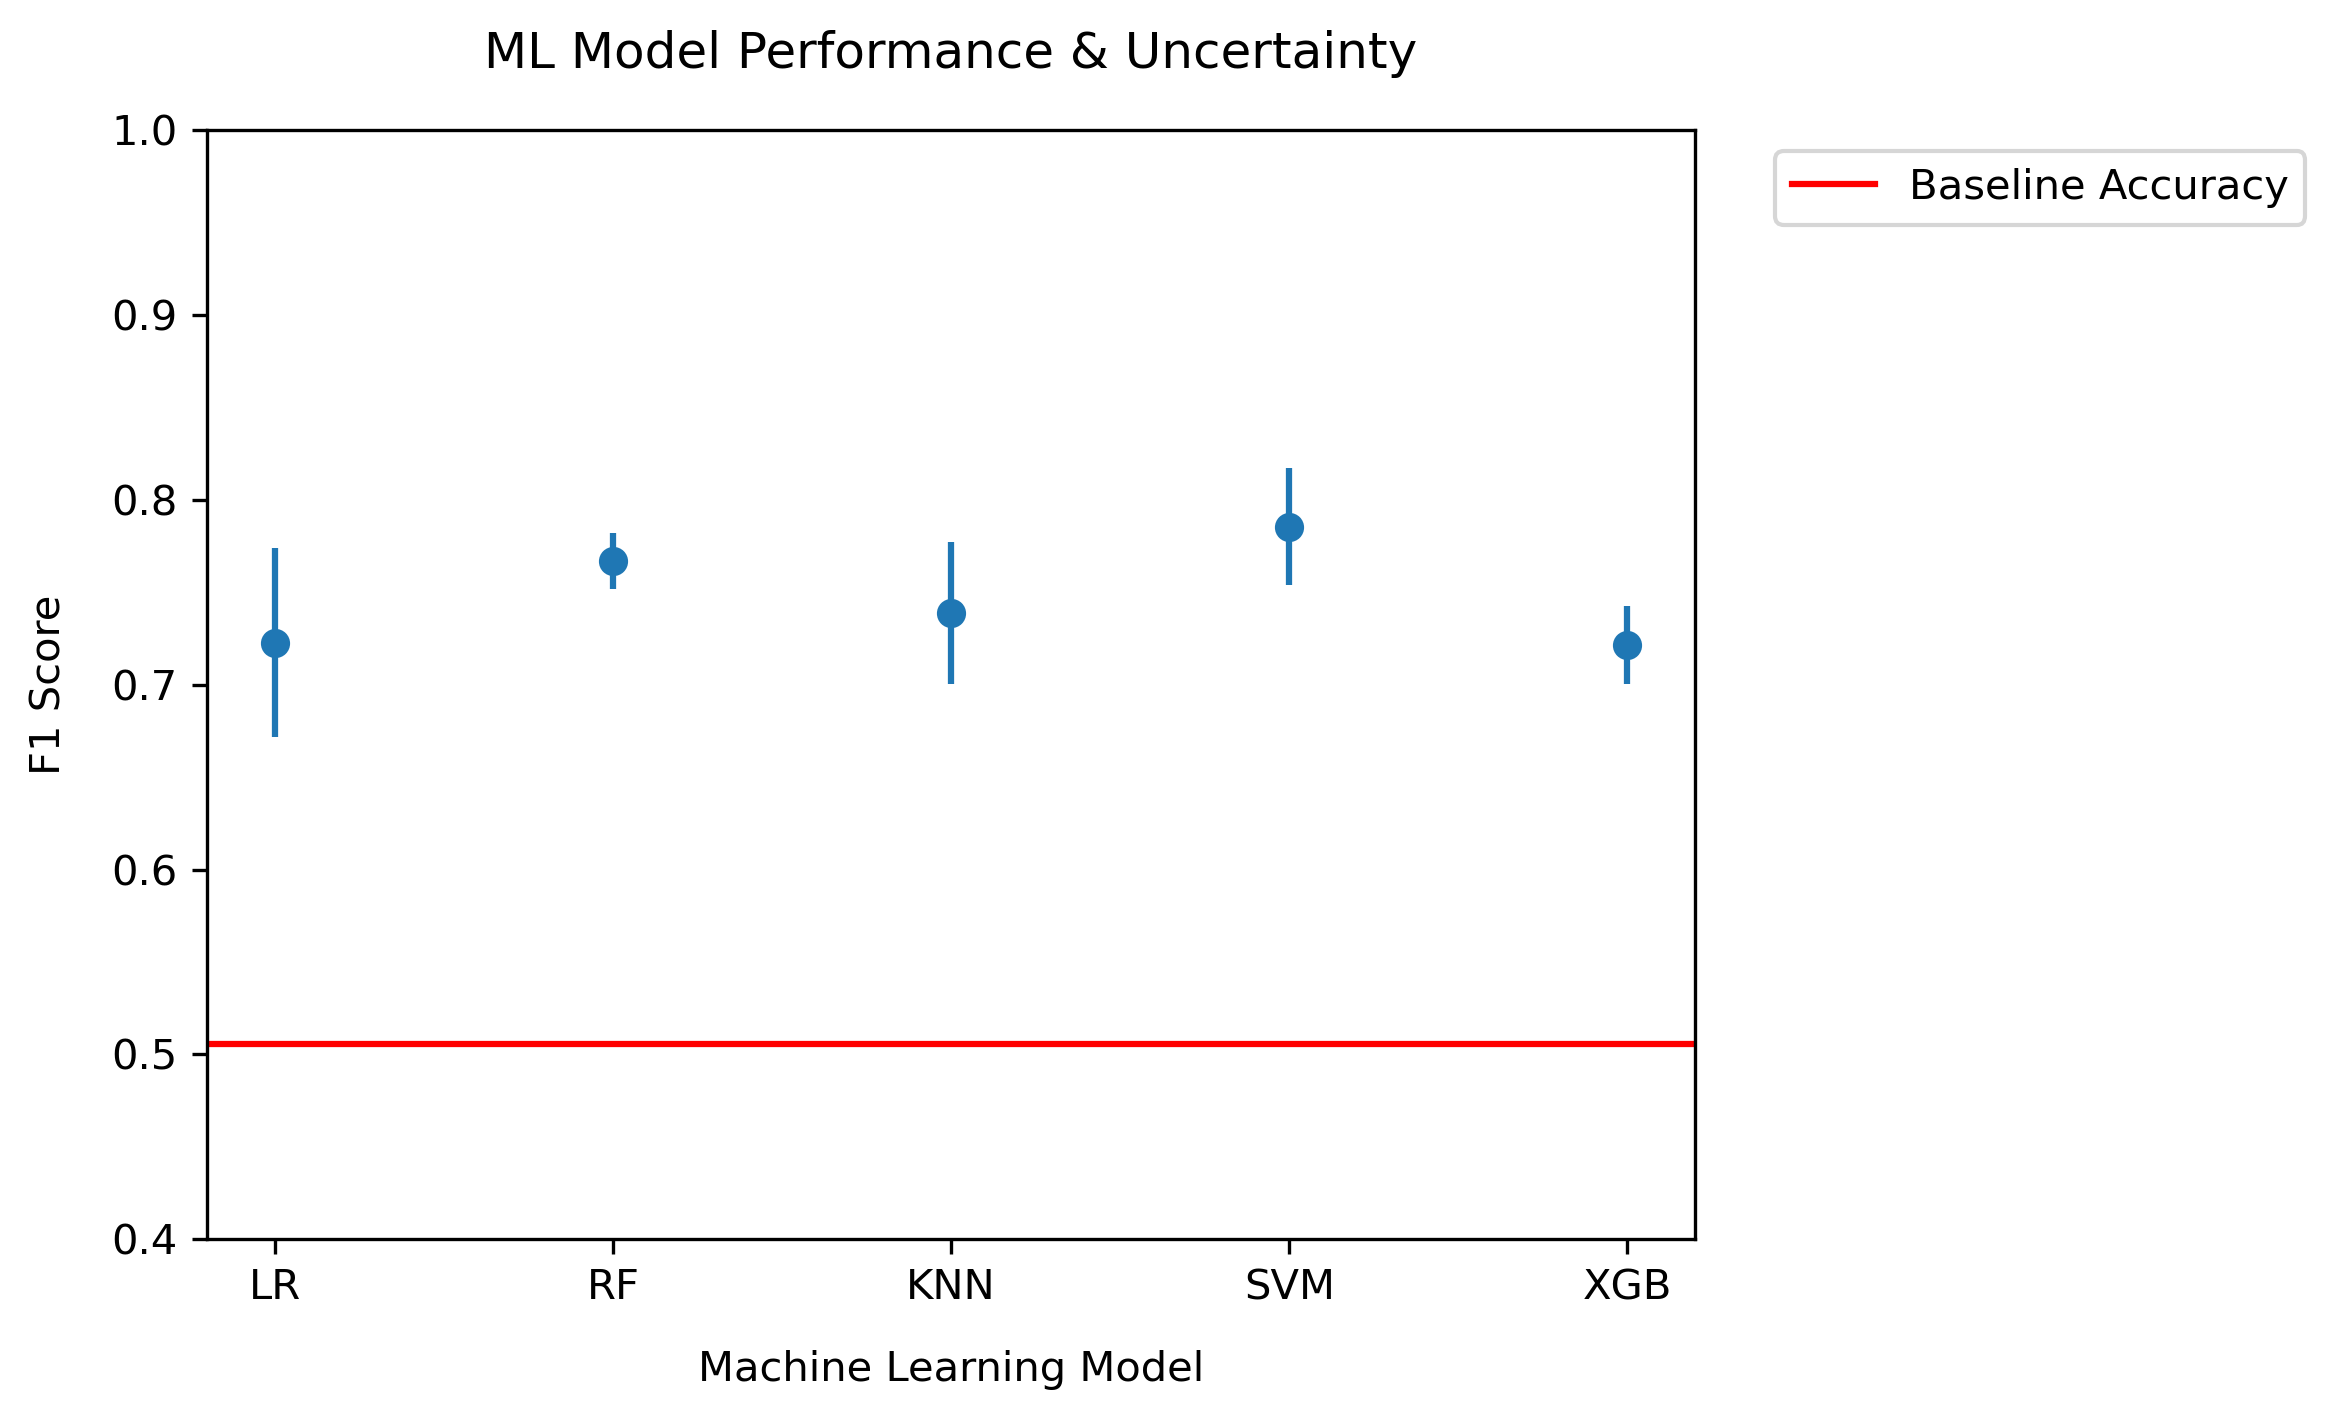

In [51]:
# plotting the performance and uncertainty of the machine learning algorithms
model_means = [lr_tmean_f, rf_tmean_f, knc_tmean_f, svc_tmean_f, xgb_tmean_f]
model_stds = [lr_tstd_f, rf_tstd_f, knc_tstd_f, svc_tstd_f, xgb_tstd_f]

plot_performance(model_means, model_stds, baseline_accuracy, 'f')